<a href="https://colab.research.google.com/github/drFahlan/tumor-cell-detection-using-small-and-large-FoV/blob/main/notebooks/EDA_and_data_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#setup

##Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**ocelot dataset link**: https://lunit-io.github.io/research/ocelot_dataset/

**KEY TAKEAWAYS**



1. total of 304 WSI from TCGA database
2. 6:2:2 stratified data splitting
3. data splitting per WSI
4. small FoV 1024x1024 pixels
5. large FoV 4096x4096 pixels (check later)

- annotation strategy refer to the link above



**METADATA**

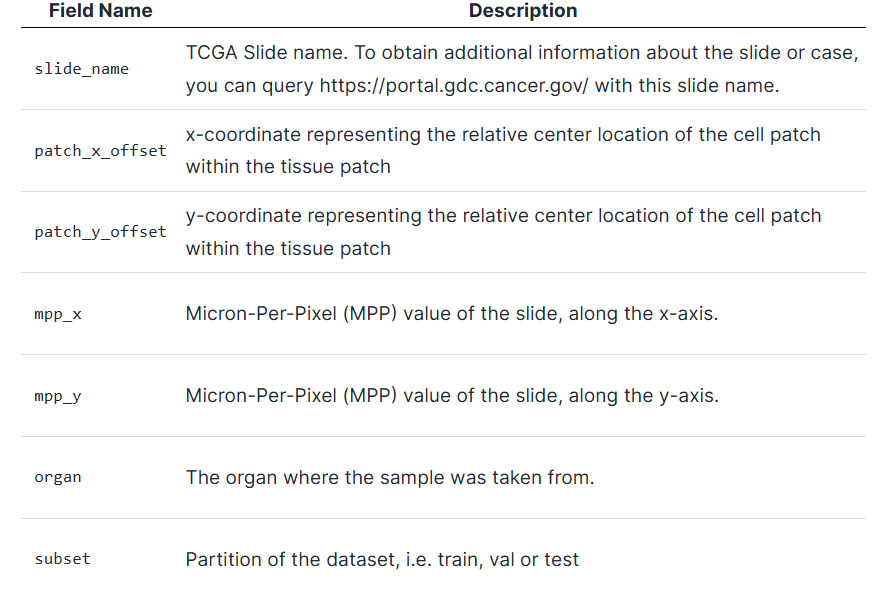

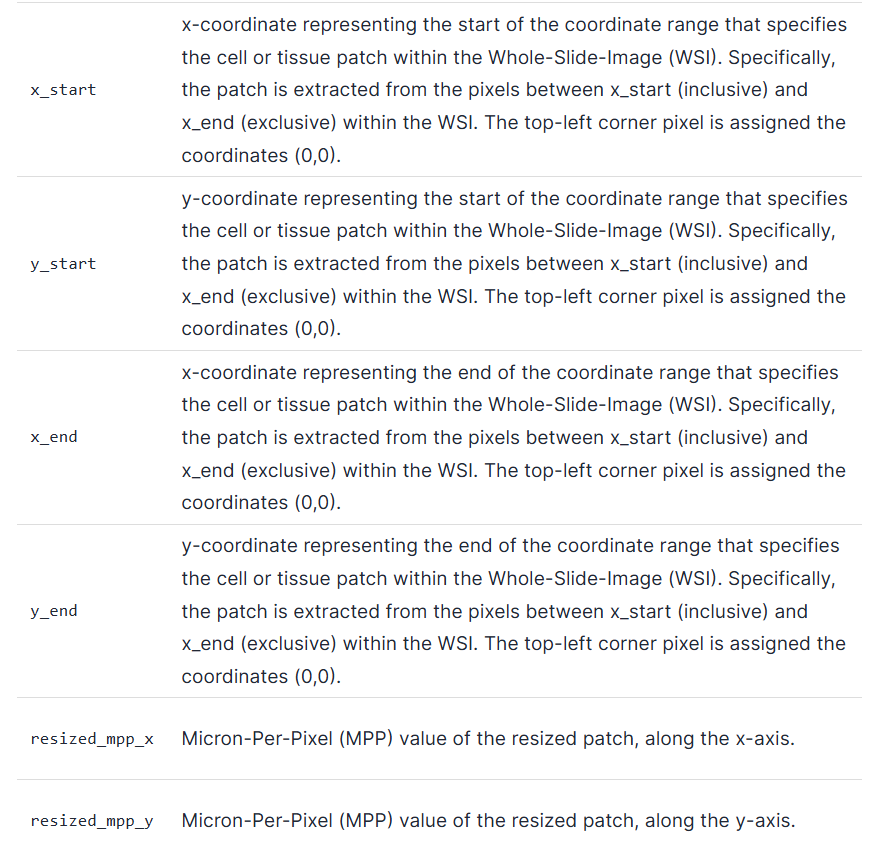

**STATISTICS**

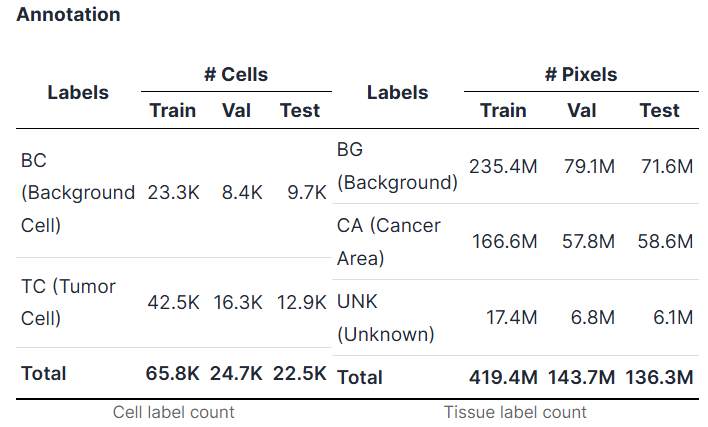

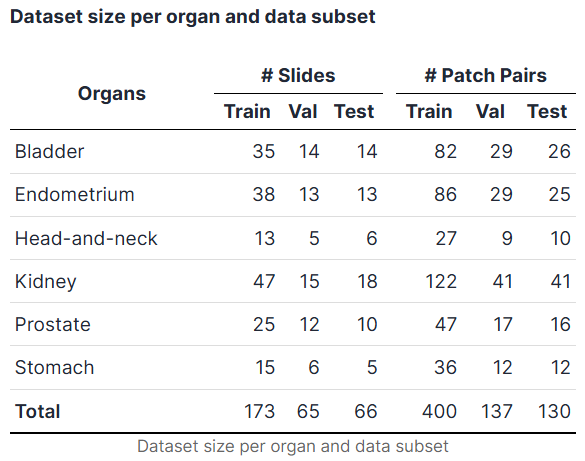

#first EDA-tissue


## data loading



1. make sure successful data loading
2. make sure successful data visualization




[TRAIN SET] Found 400 matching annotation pairs.

[VAL SET] Found 137 matching annotation pairs.

[TEST SET] Found 126 matching annotation pairs.


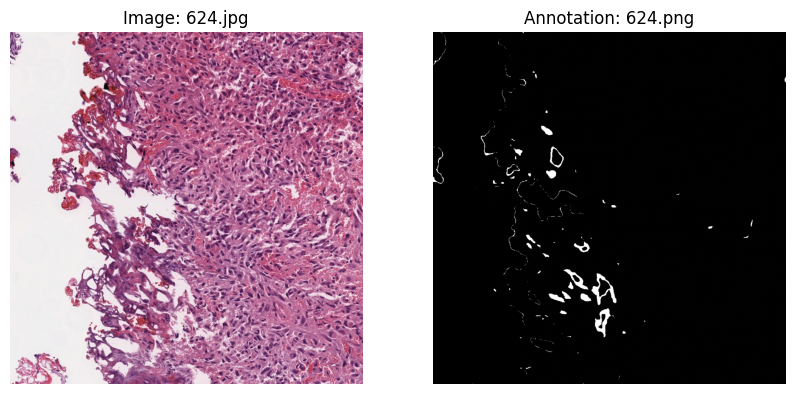

Displayed test image '624.jpg' and annotation '624.png' successfully.


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Base paths
base_path = "/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1"
sets = ["train", "val", "test"]  # Different dataset splits

# Function to find matching annotation pairs in a given subset
def find_matching_annotations(split):
    image_dir = os.path.join(base_path, f"images/{split}/tissue")
    annotation_dir = os.path.join(base_path, f"annotations/{split}/tissue")

    # Get filenames without extensions
    image_files = {os.path.splitext(f)[0]: f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))}
    annotation_files = {os.path.splitext(f)[0]: f for f in os.listdir(annotation_dir) if f.endswith('.png')}

    # Find common files
    common_files = set(image_files.keys()) & set(annotation_files.keys())

    return image_dir, annotation_dir, image_files, annotation_files, common_files

# Iterate over train, val, and test sets
for split in sets:
    image_dir, annotation_dir, image_files, annotation_files, common_files = find_matching_annotations(split)

    print(f"\n[{split.upper()} SET] Found {len(common_files)} matching annotation pairs.")

    # Display one image only for test set
    if split == "test" and common_files:
        random_file = random.choice(list(common_files))
        image_path = os.path.join(image_dir, image_files[random_file])
        annotation_path = os.path.join(annotation_dir, annotation_files[random_file])

        # Display Image & Annotation Side by Side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        try:
            # Load and display the image
            img = Image.open(image_path)
            axes[0].imshow(img)
            axes[0].set_title(f"Image: {image_files[random_file]}")
            axes[0].axis("off")

            # Load and display the annotation
            ann = Image.open(annotation_path)
            axes[1].imshow(ann, cmap="gray")
            axes[1].set_title(f"Annotation: {annotation_files[random_file]}")
            axes[1].axis("off")

            plt.show()
            print(f"Displayed test image '{image_files[random_file]}' and annotation '{annotation_files[random_file]}' successfully.")
        except Exception as e:
            print(f"Error displaying images: {e}")


##image data inspection

1. print num of images
2. check the image data format
3. check img size consistency
4. check data type


In [ ]:
# Define the path to your parent directory and the keyword
parent_directory = '/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1'

In [ ]:
import os
import pandas as pd

def count_files_in_directory(directory, keyword):
    file_counts = []

    # Walk through the directory
    for root, dirs, files in os.walk(directory):
        # Filter files by extension
        valid_files = [f for f in files if f.endswith(('.jpg', '.png', '.csv'))]

        # Check if the number of valid files is greater than 10
        if len(valid_files) > 10:
            # Extract the part of the path after the keyword
            if keyword in root:
                display_path = root.split(keyword)[1]
            else:
                display_path = root

            # Append the count of valid files and the display path
            file_counts.append((display_path, len(valid_files)))

    # Create a DataFrame from the file counts
    df = pd.DataFrame(file_counts, columns=['Directory', 'File Count'])
    return df

keyword = 'ocelot2023_v1.0.1'

# Get the file counts
file_count_df = count_files_in_directory(parent_directory, keyword)

# Display the file counts in a table
if not file_count_df.empty:
    print(file_count_df)
else:
    print("No directories with more than 10 valid files found.")


                    Directory  File Count
0    /annotations/test/tissue         126
1      /annotations/test/cell         126
2       /annotations/val/cell         137
3     /annotations/val/tissue         137
4     /annotations/train/cell         400
5   /annotations/train/tissue         400
6          /images/train/cell         400
7        /images/train/tissue         400
8          /images/val/tissue         137
9            /images/val/cell         137
10        /images/test/tissue         126
11          /images/test/cell         126


In [ ]:
import os
from collections import Counter

def find_minority_file_types(directory):
    inconsistencies = []

    # Walk through the directory
    for root, dirs, files in os.walk(directory):
        # Skip directories containing "cell" in their name
        if "cell" in os.path.basename(root):
            continue

        # Filter files by extension and count occurrences
        file_extensions = [os.path.splitext(f)[1] for f in files if f.endswith(('.jpg', '.png', '.csv'))]
        extension_counts = Counter(file_extensions)

        if extension_counts:
            # Find the most common file type
            most_common = extension_counts.most_common(1)[0]

            # Identify minority file types
            minority_types = [ext for ext, count in extension_counts.items() if count < most_common[1]]

            if minority_types:
                inconsistencies.append((root, minority_types))

    return inconsistencies

# Find minority file types
inconsistencies = find_minority_file_types(parent_directory)

# Display the inconsistencies
if inconsistencies:
    print("Inconsistencies found (minority file types):")
    for directory, minority_types in inconsistencies:
        print(f"Directory: {directory}, Minority Types: {', '.join(minority_types)}")
else:
    print("No inconsistencies found.")


No inconsistencies found.


In [ ]:
import os
import pandas as pd
from PIL import Image

def analyze_directory_contents(parent_directory):
    directory_analysis = []

    # Walk through the directory
    for root, dirs, files in os.walk(parent_directory):
        # Skip directories containing "cell" in their name
        if "cell" in os.path.basename(root):
            continue

        # Analyze one representative file in the directory
        file_info = {'Directory': root, 'Formats': set(), 'Data Types': set()}

        for file in files:
            file_path = os.path.join(root, file)
            try:
                if file.endswith('.csv'):
                    # Analyze CSV file
                    df = pd.read_csv(file_path, nrows=5)  # Read only the first 5 rows for efficiency
                    file_info['Formats'].add('CSV')
                    file_info['Data Types'].add(f"Columns: {', '.join(df.columns)}")
                    break  # Analyze only one CSV file
                elif file.endswith(('.jpg', '.png')):
                    # Analyze image file
                    img = Image.open(file_path)
                    file_info['Formats'].add(f"Image ({img.format})")
                    file_info['Data Types'].add(f"Mode: {img.mode}, Size: {img.size}")
                    break  # Analyze only one image file
            except Exception as e:
                file_info['Formats'].add(f"Error: {str(e)}")
                file_info['Data Types'].add("N/A")
                break  # Stop analyzing if an error occurs

        # Append the analysis results if there are relevant files
        if file_info['Formats']:
            directory_analysis.append(file_info)

    return directory_analysis

# Analyze directory contents
analysis_results = analyze_directory_contents(parent_directory)

# Display the analysis results
if analysis_results:
    print("Directory Analysis Results:")
    for result in analysis_results:
        print(f"Directory: {result['Directory']}")
        print(f"  Formats: {', '.join(result['Formats'])}")
        print(f"  Data Types: {'; '.join(result['Data Types'])}")
else:
    print("No relevant files found for analysis.")


Directory Analysis Results:
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/test/tissue
  Formats: Image (PNG)
  Data Types: Mode: L, Size: (1024, 1024)
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/val/tissue
  Formats: Image (PNG)
  Data Types: Mode: L, Size: (1024, 1024)
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/train/tissue
  Formats: Image (PNG)
  Data Types: Mode: L, Size: (1024, 1024)
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/train/tissue
  Formats: Image (JPEG)
  Data Types: Mode: RGB, Size: (1024, 1024)
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/val/tissue
  Formats: Image (JPEG)
  Data Types: Mode: RGB, Size: (1024, 1024)
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/test/tissue
  Formats: Image (JPEG)
  Data Types: Mode: RGB, Size: (

In [ ]:
import os
from PIL import Image

def analyze_image_sizes(parent_directory):
    directory_analysis = []

    # Walk through the directory
    for root, dirs, files in os.walk(parent_directory):
        # Skip directories containing "cell" in their name
        if "cell" in os.path.basename(root):
            continue

        image_sizes = set()
        all_sizes = []

        for file in files:
            file_path = os.path.join(root, file)
            try:
                if file.endswith(('.jpg', '.png')):
                    # Analyze image file
                    img = Image.open(file_path)
                    image_sizes.add(img.size)
                    all_sizes.append(img.size)
            except Exception as e:
                continue  # Skip errors

        # Check for inconsistencies
        if len(image_sizes) > 1:
            inconsistent_sizes = True
        else:
            inconsistent_sizes = False

        # Append the analysis results if there are relevant images
        if image_sizes:
            directory_analysis.append({
                'Directory': root,
                'Image Sizes': image_sizes,
                'Inconsistent Sizes': inconsistent_sizes
            })

    return directory_analysis

# Analyze image sizes
analysis_results = analyze_image_sizes(parent_directory)

# Display the analysis results
if analysis_results:
    print("Image Size Analysis Results:")
    for result in analysis_results:
        print(f"Directory: {result['Directory']}")
        print(f"  Image Sizes: {', '.join(map(str, result['Image Sizes']))}")
        print(f"  Inconsistent Sizes: {result['Inconsistent Sizes']}")
else:
    print("No relevant images found for analysis.")


Image Size Analysis Results:
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/test/tissue
  Image Sizes: (1024, 1024)
  Inconsistent Sizes: False
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/val/tissue
  Image Sizes: (1024, 1024)
  Inconsistent Sizes: False
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/train/tissue
  Image Sizes: (1024, 1024)
  Inconsistent Sizes: False
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/train/tissue
  Image Sizes: (1024, 1024)
  Inconsistent Sizes: False
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/val/tissue
  Image Sizes: (1024, 1024)
  Inconsistent Sizes: False
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/test/tissue
  Image Sizes: (1024, 1024)
  Inconsistent Sizes: False


##annotation verification



1. completeness
2. check if the format matches our need
3. coordinate sanity check
4. class distribution
5. metadata inspection



**COVERED IN PREVIOUS SECTIONS**

In [ ]:
# Define metadata file path
metadata_json_path = "/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/metadata.json"

In [ ]:
import os
import json
from collections import Counter

def analyze_metadata(json_path):
    with open(json_path, 'r') as f:
        metadata = json.load(f)

    sample_pairs = metadata.get("sample_pairs", {})

    # Count the number of objects inside sample_pairs
    num_samples = len(sample_pairs)

    # Check for incomplete attributes
    required_keys = {"slide_name", "cell", "tissue", "patch_x_offset", "patch_y_offset", "mpp_x", "mpp_y", "organ", "subset"}
    incomplete_samples = []

    for key, value in sample_pairs.items():
        if not required_keys.issubset(value.keys()):
            incomplete_samples.append(key)

    # Count objects belonging to train, val, test
    subset_counts = Counter(value["subset"] for value in sample_pairs.values())

    # Count objects belonging to each organ
    organ_counts = Counter(value["organ"] for value in sample_pairs.values())

    # Check x_start < x_end and y_start < y_end inside tissue
    tissue_issues = [key for key, value in sample_pairs.items()
                     if value["tissue"]["x_start"] >= value["tissue"]["x_end"]
                     or value["tissue"]["y_start"] >= value["tissue"]["y_end"]]

    # Check consistency of resized_mpp_x and resized_mpp_y in tissue
    resized_mpp_x_counts = Counter(value["tissue"]["resized_mpp_x"] for value in sample_pairs.values())
    resized_mpp_y_counts = Counter(value["tissue"]["resized_mpp_y"] for value in sample_pairs.values())
    most_common_resized_mpp_x, count_resized_mpp_x = resized_mpp_x_counts.most_common(1)[0]
    most_common_resized_mpp_y, count_resized_mpp_y = resized_mpp_y_counts.most_common(1)[0]
    inconsistent_resized_mpp = {key: (value["tissue"]["resized_mpp_x"], value["tissue"]["resized_mpp_y"])
                                for key, value in sample_pairs.items()
                                if value["tissue"]["resized_mpp_x"] != most_common_resized_mpp_x or
                                   value["tissue"]["resized_mpp_y"] != most_common_resized_mpp_y}

    # Check consistency of mpp_x and mpp_y
    mpp_x_counts = Counter(value["mpp_x"] for value in sample_pairs.values())
    mpp_y_counts = Counter(value["mpp_y"] for value in sample_pairs.values())
    most_common_mpp_x, count_mpp_x = mpp_x_counts.most_common(1)[0]
    most_common_mpp_y, count_mpp_y = mpp_y_counts.most_common(1)[0]
    inconsistent_mpp = {key: (value["mpp_x"], value["mpp_y"])
                         for key, value in sample_pairs.items()
                         if value["mpp_x"] != most_common_mpp_x or
                            value["mpp_y"] != most_common_mpp_y}

    # Print results
    print(f"Total number of sample pairs: {num_samples}")
    print(f"Incomplete samples: {incomplete_samples}")
    print(f"Subset counts: {subset_counts}")
    print(f"Organ counts: {organ_counts}")
    print(f"Tissue issues (x_start >= x_end or y_start >= y_end): {tissue_issues}")
    print(f"Most common resized_mpp_x: {most_common_resized_mpp_x} (Occurrences: {count_resized_mpp_x})")
    print(f"Most common resized_mpp_y: {most_common_resized_mpp_y} (Occurrences: {count_resized_mpp_y})")
    print(f"Number of inconsistent resized_mpp values: {len(inconsistent_resized_mpp)}")
    print(f"Inconsistent resized_mpp values: {inconsistent_resized_mpp}")
    print(f"Most common mpp_x: {most_common_mpp_x} (Occurrences: {count_mpp_x})")
    print(f"Most common mpp_y: {most_common_mpp_y} (Occurrences: {count_mpp_y})")
    print(f"Number of inconsistent mpp values: {len(inconsistent_mpp)}")
    print(f"Inconsistent mpp values: {inconsistent_mpp}")
# Run analysis
analyze_metadata(metadata_json_path)


Total number of sample pairs: 663
Incomplete samples: []
Subset counts: Counter({'train': 400, 'val': 137, 'test': 126})
Organ counts: Counter({'kidney': 204, 'endometrium': 138, 'bladder': 135, 'prostate': 80, 'stomach': 60, 'head-and-neck': 46})
Tissue issues (x_start >= x_end or y_start >= y_end): []
Most common resized_mpp_x: 0.7776640497904737 (Occurrences: 112)
Most common resized_mpp_y: 0.7776640497904737 (Occurrences: 112)
Number of inconsistent resized_mpp values: 551
Inconsistent resized_mpp values: {'001': (0.7778421905823052, 0.7778421905823052), '002': (0.7778421905823052, 0.7778421905823052), '003': (0.7777300858288072, 0.7777300858288072), '004': (0.7777900241489988, 0.7777900241489988), '005': (0.7777900241489988, 0.7777900241489988), '006': (0.7777900241489988, 0.7777900241489988), '007': (0.7777900241489988, 0.7777900241489988), '008': (0.7777900241489988, 0.7777900241489988), '009': (0.7777900241489988, 0.7777900241489988), '010': (0.7777900241489988, 0.7777900241489

In [ ]:
import os
import json
import pandas as pd
from collections import Counter

def analyze_metadata(json_path):
    with open(json_path, 'r') as f:
        metadata = json.load(f)

    sample_pairs = metadata.get("sample_pairs", {})

    # Count objects belonging to each subset-organ combination
    subset_organ_counts = Counter((value["subset"], value["organ"]) for value in sample_pairs.values())

    # Create a DataFrame with organs as rows and subsets as columns
    subset_organ_df = pd.DataFrame.from_dict(subset_organ_counts, orient='index', columns=["Count"])
    subset_organ_df.index = pd.MultiIndex.from_tuples(subset_organ_df.index, names=["Subset", "Organ"])
    subset_organ_df = subset_organ_df.unstack(level=0, fill_value=0)
    subset_organ_df.columns = subset_organ_df.columns.droplevel()

    # Reorder columns to Train, Val, Test
    subset_organ_df = subset_organ_df.reindex(columns=["train", "val", "test"], fill_value=0)

    # Print table
    print("Subset-Organ Distribution:")
    print(subset_organ_df.to_string())

# Run analysis
analyze_metadata(metadata_json_path)

Subset-Organ Distribution:
Subset         train  val  test
Organ                          
bladder           82   29    24
endometrium       86   29    23
head-and-neck     27    9    10
kidney           122   41    41
prostate          47   17    16
stomach           36   12    12


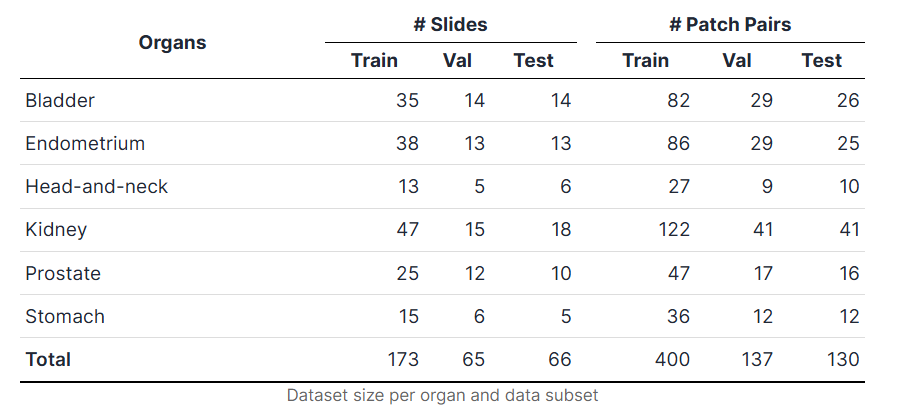

2 sample in test-bladder
2 sample in test-endometrium are excluded


In [ ]:
import os
import numpy as np
from PIL import Image
from collections import Counter
import pandas as pd

def count_pixel_intensities(folder_path, subset_name):
    pixel_counts = Counter()

    for file in os.listdir(folder_path):
        if file.endswith(('.jpg', '.png', '.tif')):  # Adjust formats if needed
            img_path = os.path.join(folder_path, file)
            try:
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img_array = np.array(img).flatten()  # Flatten to 1D array
                pixel_counts.update(img_array)  # Count occurrences
            except Exception as e:
                print(f"Error processing {file} in {subset_name}: {e}")

    # Convert results to DataFrame for better visualization
    df = pd.DataFrame(sorted(pixel_counts.items()), columns=["Pixel Intensity", "Count"])

    print(f"\nPixel Intensity Distribution in {subset_name} Tissue Annotation Images:")
    print(df.to_string(index=False))  # Print table

# Define the base path
base_path = "/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations"

# Iterate over train, val, and test subsets
for subset in ["train", "val", "test"]:
    tissue_annotation_folder = os.path.join(base_path, subset, "tissue")
    if os.path.exists(tissue_annotation_folder):
        count_pixel_intensities(tissue_annotation_folder, subset)
    else:
        print(f"Folder not found: {tissue_annotation_folder}")



Pixel Intensity Distribution in train Tissue Annotation Images:
 Pixel Intensity     Count
               1 235409146
               2 166661770
             255  17359484

Pixel Intensity Distribution in val Tissue Annotation Images:
 Pixel Intensity    Count
               1 79082000
               2 57805340
             255  6767572

Pixel Intensity Distribution in test Tissue Annotation Images:
 Pixel Intensity    Count
               1 67427541
               2 58590757
             255  6102278


#EDA-tissue

In [27]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

def normalize_albumentations(image):
    # Albumentations normalization matching your pipeline
    transform = A.Compose([
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2()
    ])
    transformed = transform(image=image)
    return transformed["image"]

def display_images(folder_path):
    # Get a random image from the folder (only .jpg images)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]
    if not image_files:
        raise ValueError("No .jpg images found in the folder!")
    random_image = random.choice(image_files)
    image_path = os.path.join(folder_path, random_image)

    # Load the image using cv2 (BGR) and convert to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply Albumentations normalization
    normalized_tensor = normalize_albumentations(image)

    # Print pixel value statistics for the normalized tensor
    print("Normalized tensor stats:")
    print("Min:", torch.min(normalized_tensor).item(), "Max:", torch.max(normalized_tensor).item())

    # Convert normalized tensor to numpy for display (shape becomes HWC)
    normalized_np = normalized_tensor.permute(1, 2, 0).numpy()

    # Denormalize for display: x_display = x * std + mean
    denormalized_np = normalized_np * 0.5 + 0.5
    denormalized_np = np.clip(denormalized_np, 0, 1)

    # Plot the images: original, raw normalized, and denormalized
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(normalized_np)  # Raw normalized image may appear off due to its range
    axes[1].set_title("Raw Normalized Image\n(not scaled for display)")
    axes[1].axis("off")

    axes[2].imshow(denormalized_np)
    axes[2].set_title("Denormalized Image")
    axes[2].axis("off")

    plt.show()

    # Print sample pixel values (top-left 3x3 region) for all three versions
    print("\nSample pixel values (top-left 3x3 region):")
    print("Original Image (RGB, 0-255):")
    print(image[:3, :3, :])

    print("\nRaw Normalized Image (may include negative values):")
    print(normalized_np[:3, :3, :])

    print("\nDenormalized Image (values in [0,1]):")
    print(denormalized_np[:3, :3, :])


Normalized tensor stats:
Min: -1.0 Max: 1.0


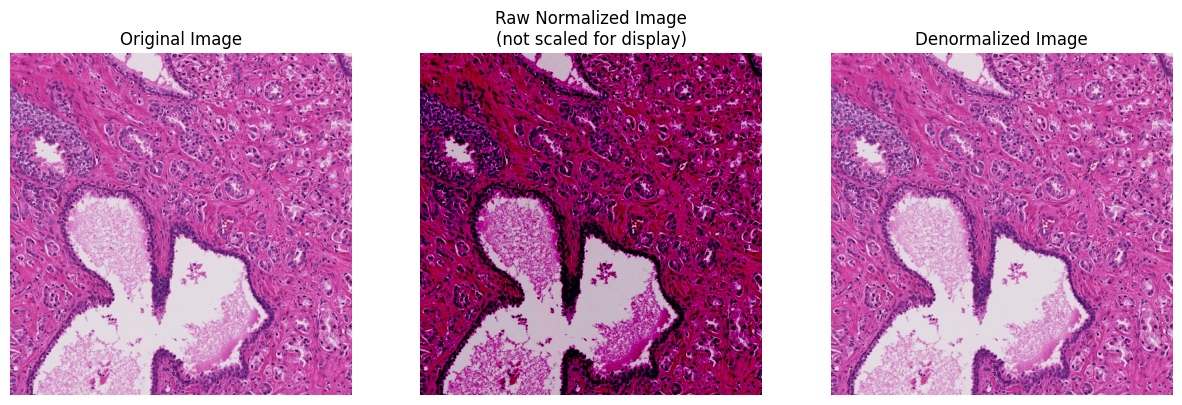


Sample pixel values (top-left 3x3 region):
Original Image (RGB, 0-255):
[[[162  49 131]
  [171  55 138]
  [172  53 137]]

 [[173  55 139]
  [165  46 130]
  [155  33 118]]

 [[162  38 126]
  [165  38 127]
  [164  35 125]]]

Raw Normalized Image (may include negative values):
[[[ 0.27058825 -0.6156863   0.02745098]
  [ 0.34117648 -0.5686275   0.08235294]
  [ 0.34901962 -0.58431375  0.07450981]]

 [[ 0.35686275 -0.5686275   0.09019608]
  [ 0.29411766 -0.6392157   0.01960784]
  [ 0.21568629 -0.7411765  -0.07450981]]

 [[ 0.27058825 -0.7019608  -0.01176471]
  [ 0.29411766 -0.7019608  -0.00392157]
  [ 0.28627452 -0.7254902  -0.01960784]]]

Denormalized Image (values in [0,1]):
[[[0.63529414 0.19215685 0.5137255 ]
  [0.67058825 0.21568626 0.5411765 ]
  [0.6745098  0.20784312 0.5372549 ]]

 [[0.6784314  0.21568626 0.54509807]
  [0.64705884 0.18039215 0.50980395]
  [0.60784316 0.12941176 0.4627451 ]]

 [[0.63529414 0.1490196  0.49411765]
  [0.64705884 0.1490196  0.49803922]
  [0.6431373  0.137

In [32]:
# Provide your image folder path here
folder_path = "/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/val/tissue"
display_images(folder_path)

**WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9058824..1.0].**